This skeleton code will get you started with the assignment.

For this assignment you will need at least:

- Pytorch 1.13+
- Sklearn
- Matplotlib

In [1]:
import numpy as np
import torch
import torch.nn as nn
from IPython.display import Audio
import matplotlib.pyplot as plt
from torch import optim
from torchsummary import summary

### Data Loading
The data consists of waveforms of audioclips sampled 8000 times per second (8 khz).
The data is stored in 16 bit precision to reduce storage size. We first need to
convert the waveforms to 32 bit precision.

In [2]:
sampling_rate = 8_000
languages = ["de", "en", "es", "fr", "nl", "pt"]
language_dict = {languages[i]: i for i in range(len(languages))}

X_train, y_train = np.load("dataset/inputs_train_fp16.npy"), np.load(
    "dataset/targets_train_int8.npy"
)
X_test, y_test = np.load("dataset/inputs_test_fp16.npy"), np.load(
    "dataset/targets_test_int8.npy"
)

X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)


Change the `selected_language` to any of the 6 language codes, and re-run the cell below to hear some random clips from the training data.

In [21]:
selected_language = "nl"
idxs = np.where(y_train == language_dict[selected_language])[0]
idx = np.random.choice(idxs)

Audio(X_train[idx], rate=sampling_rate)


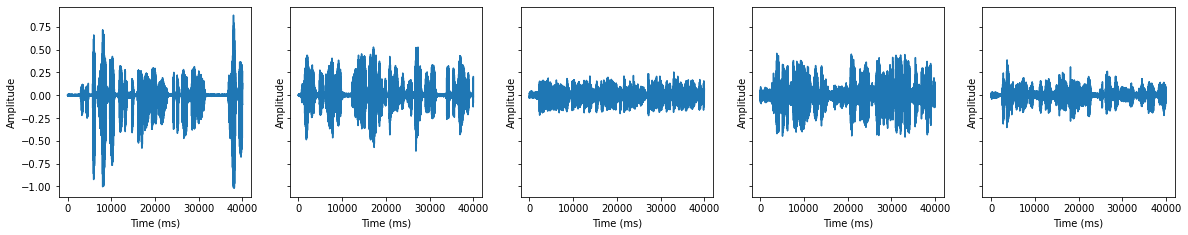

In [ ]:
indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey = True)
for ax, audio_index in zip(axes,indexes_random):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')


### Data pre-processing

It is important that data preprocessing takes place in the model itself,
as only the model will be uploaded to the competition server.

So, rather than the usual, we will perform normalization and other preprocessing
steps as layers of the network. To help you with this, we provide an example of
a bogus normalization below.


Here, we multiply the input by a constant and subtract the max of each sample.
Follow this format to create your own normalization layer(s).

In [3]:
class ExampleNormalization(nn.Module):
    def __init__(self, constant):
        super().__init__()
        # register_buffer ensures that the constant is saved with the model
        self.register_buffer("constant", torch.tensor(constant))

    def forward(self, x):
        # torch no_grad is used since we don't want to save the gradient
        # for the pre-processing steps
        with torch.no_grad():
            # we multiply the input by the constant
            x = x * self.constant
            # we subtract the max of each sample in the batch
            maxs = torch.max(x, 2, True).values
            x = x - maxs
        return x

constant = 42
example_normalization = ExampleNormalization(constant)

In [4]:
class Normalization(nn.Module):
    def __init__(self):
        super().__init__()
        # register_buffer ensures that the constant is saved with the model

    def forward(self, x):
        # torch no_grad is used since we don't want to save the gradient
        # for the pre-processing steps
        with torch.no_grad():
            # we subtract the mean from the sample
            x = x - torch.mean(x)
            # we divide by the data
            std = torch.std(x)
            x = x/std
            
        return x

normalization = Normalization()

The normalization layer(s) can then be added to the beginning of your model like any other layer.

In [5]:
#test to see what is happening
inputs = torch.tensor([1.0,200.0,2.0,30.0])
model = nn.Sequential(normalization)
model(inputs)

tensor([-0.5998,  1.4851, -0.5893, -0.2960])

In [6]:
tensor_X_train = torch.tensor(X_train)
normalized_tensor = normalization(tensor_X_train)
normalized_array = np.array(normalized_tensor)

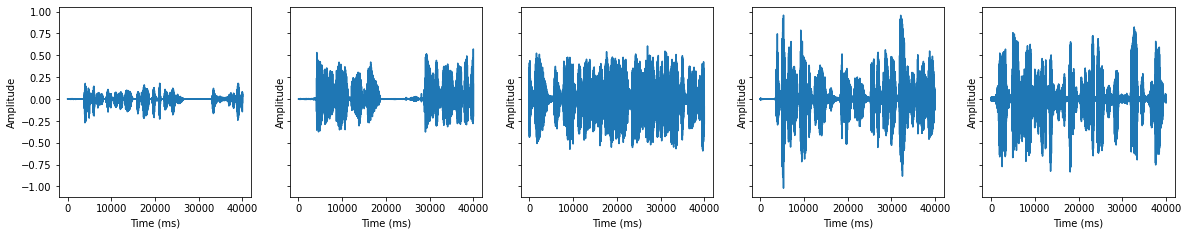

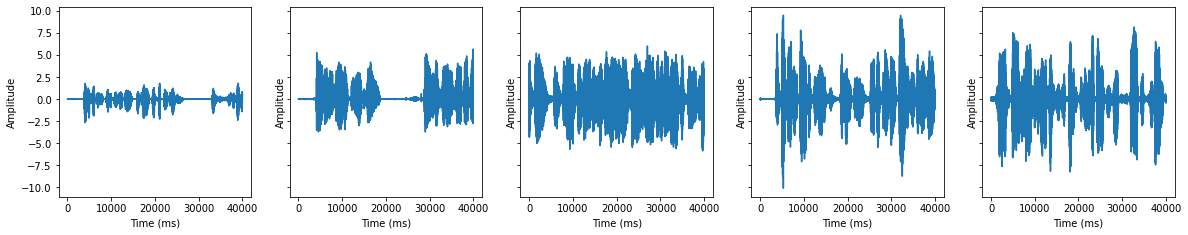

In [ ]:
indexes = [10,11,12,13,14]

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, X_train[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

#indexes_random = np.random.choice(6000, 5)

time = np.linspace(0, 39999, 40000)

fig, axes = plt.subplots(1,5, figsize = (20,3.5), sharey=True)

for ax, audio_index in zip(axes,indexes):
    ax.plot(time, normalized_array[audio_index])
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude')

[       nan        nan -11.465049 ...        nan        nan        nan]


c:\Users\flori\anaconda3\lib\site-packages\IPython\lib\display.py:175: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


### Build Model

build the architecture and train the model for en and sp

In [7]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [105]:
#Isolating english and spanish for the initial model creation

idxs = np.where((y_train == language_dict['en'])|(y_train == language_dict['es'])) 
idxs_test = np.where((y_test == language_dict['en'])|(y_test == language_dict['es'])) 

y_train_sub = y_train[idxs]
X_train_sub = normalized_tensor[idxs]

y_test_sub = y_train[idxs_test]
X_test_sub = normalized_tensor[idxs_test]


In [99]:

# Create a sequential model
model = nn.Sequential()

# Add convolutional and pooling layers
#notebook used Conv2d and MaxPool2d but our data is 1D 
model.add_module('Conv_1', nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool1d(kernel_size=2))

model.add_module('Conv_2', nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3))
model.add_module('Relu_2', nn.ReLU())
model.add_module('MaxPool_2', nn.MaxPool1d(kernel_size=2))

model.add_module('Conv_3', nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3))
model.add_module('Relu_3', nn.ReLU())

model = model.to(device)

In [97]:
#input_shape=(128,1000,3)

CNNmodel = nn.Sequential()

model.add_module('Conv_1', nn.Conv1d(in_channels=1, out_channels=32, kernel_size=1))
model.add_module('Relu_1', nn.ReLU())
model.add_module('MaxPool_1', nn.MaxPool1d(kernel_size=1))
CNNmodel.add_module('Dropout_1',nn.Dropout(0.2))

CNNmodel.add_module('Conv_2', nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1))
CNNmodel.add_module('Relu_2', nn.ReLU())
CNNmodel.add_module('MaxPool_2', nn.MaxPool1d(kernel_size=1))
CNNmodel.add_module('Dropout_2',nn.Dropout(0.2))

CNNmodel.add_module('Conv_3', nn.Conv1d(in_channels=64, out_channels=64, kernel_size=1))
CNNmodel.add_module('Flatten', nn.Flatten())
model.add_module('Linear_1', nn.Linear(in_features=64*3*3, out_features=64, bias=True))
CNNmodel.add_module('Relu_3', nn.ReLU())

CNNmodel.add_module('Dropout_3',nn.Dropout(0.2))
CNNmodel.add_module('Linear_2', nn.Linear(in_features=64, out_features=32, bias=True))
CNNmodel.add_module('Relu_4', nn.ReLU())
CNNmodel.add_module('Linear_3', nn.Linear(in_features=64, out_features=24, bias=True))
CNNmodel.add_module('Out_activation', nn.Softmax(-1))

In [81]:
print(X_train_sub.shape)

#should be batch size height, width, depth

torch.Size([2000, 40000])


In [100]:

in_shape = X_train_sub.shape
summary(model, input_size=(in_shape))

#expected: [32, 1, 3, 3], but got 3-dimensional input of size [2, 2000, 40000]
#[64, 32, 3, 3]

OutOfMemoryError: CUDA out of memory. Tried to allocate 612.00 MiB (GPU 0; 4.00 GiB total capacity; 2.38 GiB already allocated; 0 bytes free; 2.99 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Model saving

We need to save the model using torchscript, in order to upload the model file to the competition server.
This may give errors for the following reason:

* In your model class, or layer classes, you use numpy functions or arrays, rather than tensors.

Thus make sure that you use torch tensors and functions inside these classes. Almost any numpy function
can also be performed using torch. Look at the torch documentation for further reference.

Saving the model to torchscript

In [ ]:
torch.jit.save(torch.jit.script(model), "model_test.pt")

### Loading the model from torchscript

This is what the competition server will be doing with your uploaded model.

In [ ]:
model = torch.jit.load("model_test.pt")

In [ ]:
model(inputs)

tensor([[[ 0.3845]],

        [[-9.1447]],

        [[-1.4845]],

        [[24.0791]]], grad_fn=<ViewBackward0>)

### Making a PCA plot of the output space

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Below we generate some random model outptus and targets, you must replace these with your own model's
output and the corresponding true targets.

In [ ]:
model_outputs = torch.randn(1200, 6)
targets = torch.randint(0, 6, (1200,))

In [ ]:
outputs_PCA = PCA(n_components=2).fit_transform(model_outputs)

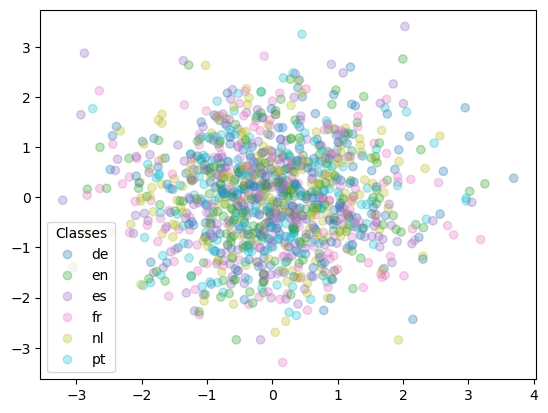

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(*outputs_PCA.T, c=targets, cmap="tab10", alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
# set legend labels as languages
for i, text in enumerate(legend1.get_texts()):
    text.set_text(languages[i]);